## Assignment 9 NLP-- Disaster in Tweets

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout,Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"


#### Ingest

In [2]:
train = pd.read_csv('train.csv', usecols = ['id', 'text', 'target'])
train.shape
test = pd.read_csv('test.csv', usecols = ['id', 'text'])
test.shape

(7613, 3)

(3263, 2)

In [3]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

#### Data Preprocessing

In [4]:
#Tokenize text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#num_words = 100
#oov_t = ''
pad_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer(num_words = 100, oov_token = '<OOV>')
tokenizer.fit_on_texts(train['text'])
word_index = tokenizer.word_index
len(word_index)
sequence1 = tokenizer.texts_to_sequences(train['text'])
pad1 = pad_sequences(sequence1, padding = 'post') #value = -1?
print(pad1)
#print(word_index)

22701

[[ 1  1 25 ...  0  0  0]
 [ 1 46  1 ...  0  0  0]
 [41  1  1 ...  0  0  0]
 ...
 [ 1  1  1 ...  0  0  0]
 [79  1 42 ...  0  0  0]
 [ 5  1 55 ...  0  0  0]]


Test Data Preprocessing

In [5]:
tokenizer = Tokenizer(num_words = 100, oov_token = '<OOV>')
tokenizer.fit_on_texts(test['text'])
word_index_t = tokenizer.word_index
len(word_index_t)
sequence2 = tokenizer.texts_to_sequences(test['text'])
pad2 = pad_sequences(sequence2, padding = 'post') #value = -1?
print(pad2)
#print(word_index_t)

12819

[[35  1  6 ...  0  0  0]
 [ 1 54  1 ...  0  0  0]
 [76 12  6 ...  0  0  0]
 ...
 [ 1  1  1 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]
 [ 1 59  1 ...  0  0  0]]


In [6]:
pad1[0]

array([ 1,  1, 25,  5,  1,  9, 22,  1,  1,  1,  1, 90, 41,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(pad1, train['target'], train_size = 0.8, random_state=42)

In [46]:
len(X_train)

6090

#### Model-- RNN 1

In [57]:
#embedding = tf.keras.layers.Embedding(22702, 200
                                      #input_length = 40
                                    # )

#num_words = len(tokenizer.word_index) + 1
#embedding_matrix = np.zeros((num_words, 100))

embedding1 = tf.keras.layers.Embedding(
    len(word_index) + 1,
    200,
    trainable = True
)

model1 = tf.keras.Sequential([embedding1,
                              tf.keras.layers.Bidirectional(
                              tf.keras.layers.LSTM(128, dropout = 0.2)),
                              tf.keras.layers.Dense(1, activation = 'sigmoid')
                             ])

#model1.summary()

model1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy', 'Precision', 'Recall']
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

history = model1.fit(X_train, y_train, 
                     validation_data = (X_test, y_test), 
                     epochs = 30,
                    callbacks = callbacks)


Epoch 1/30
191/191 [==============================] - 19s 84ms/step - loss: 0.6821 - accuracy: 0.5526 - precision: 0.4427 - recall: 0.1975 - val_loss: 0.6508 - val_accuracy: 0.6297 - val_precision: 0.5601 - val_recall: 0.6102
Epoch 2/30
191/191 [==============================] - 16s 86ms/step - loss: 0.6404 - accuracy: 0.6421 - precision: 0.5991 - recall: 0.4996 - val_loss: 0.6061 - val_accuracy: 0.6881 - val_precision: 0.6347 - val_recall: 0.6317
Epoch 3/30
191/191 [==============================] - 18s 95ms/step - loss: 0.5878 - accuracy: 0.6801 - precision: 0.6326 - recall: 0.6077 - val_loss: 0.5761 - val_accuracy: 0.7150 - val_precision: 0.6783 - val_recall: 0.6302
Epoch 4/30
191/191 [==============================] - 16s 85ms/step - loss: 0.5555 - accuracy: 0.7146 - precision: 0.6908 - recall: 0.6311 - val_loss: 0.5719 - val_accuracy: 0.7078 - val_precision: 0.7008 - val_recall: 0.5485
Epoch 5/30
191/191 [==============================] - 16s 81ms/step - loss: 0.5660 - accuracy: 0

In [13]:
pred1 = model1.predict(pad2)
pred12= np.concatenate(pred1).round().astype(int)
pred12

array([0, 0, 0, ..., 0, 1, 0])

In [14]:
sub1 = pd.DataFrame(data={'target': pred12}, index=test['id'])
sub1.index = sub1.index.rename('id')
sub1.to_csv('sub1.csv')

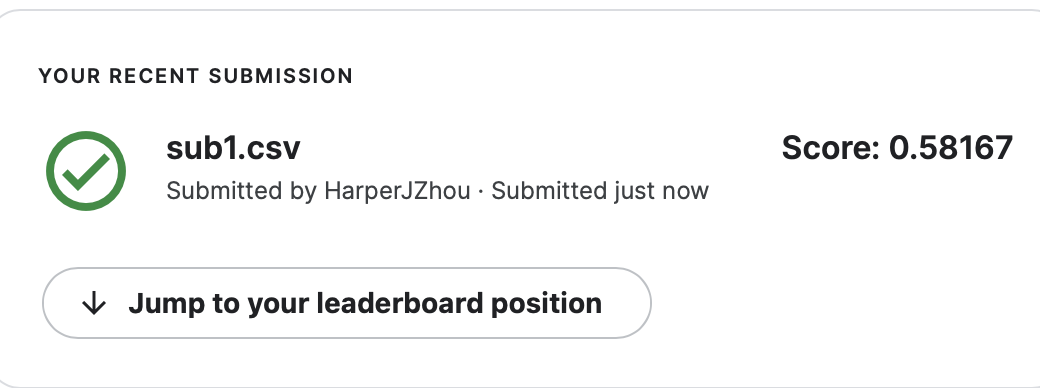

#### Model --RNN 2

In [53]:
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 200))

embedding2 = tf.keras.layers.Embedding(
    len(word_index) + 1,
    200,
    input_length = 100,
    weights=[embedding_matrix],
    trainable = True
)

model2 = tf.keras.Sequential([embedding2,
                              tf.keras.layers.LSTM(100, return_sequences=True),
                              tf.keras.layers.LSTM(200),
                              tf.keras.layers.Dense(1, activation = 'sigmoid')
                             ])

#model1.summary()

model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy', 'Precision', 'Recall']
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

#Y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
#Y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
history = model2.fit(X_train, y_train, 
                     #validation_data = (X_test, y_test), 
                     epochs = 30,
                    callbacks = callbacks)


Epoch 1/30
191/191 [==============================] - 18s 85ms/step - loss: 0.6748 - accuracy: 0.5700 - precision: 0.5185 - recall: 0.1606
Epoch 2/30
191/191 [==============================] - 16s 83ms/step - loss: 0.5719 - accuracy: 0.7056 - precision: 0.6771 - recall: 0.6109
Epoch 3/30
191/191 [==============================] - 16s 86ms/step - loss: 0.5624 - accuracy: 0.7170 - precision: 0.6992 - recall: 0.5971
Epoch 4/30
191/191 [==============================] - 16s 84ms/step - loss: 0.5712 - accuracy: 0.6957 - precision: 0.6845 - recall: 0.5535
Epoch 5/30
191/191 [==============================] - 16s 85ms/step - loss: 0.5577 - accuracy: 0.7148 - precision: 0.6939 - recall: 0.5812
Epoch 6/30
191/191 [==============================] - 16s 84ms/step - loss: 0.5534 - accuracy: 0.7151 - precision: 0.7012 - recall: 0.6045
Epoch 7/30
191/191 [==============================] - 16s 84ms/step - loss: 0.5519 - accuracy: 0.7176 - precision: 0.7114 - recall: 0.6128
Epoch 8/30
191/191 [=======

In [56]:
pred2 = model2.predict(pad2)
pred22= np.concatenate(pred2).round().astype(int)
pred22
sub2 = pd.DataFrame(data={'target': pred22}, index=test['id'])
sub2.index = sub2.index.rename('id')
sub2.to_csv('sub2.csv')

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
model2.summary()
model1.summary()